## Lesson IV: Introduction to Customer Lifetime Value


This is based on https://github.com/hariharan2305/DailyKnowledge/blob/master/Customer%20Lifetime%20Value/Customer%20Lifetime%20Value%20(CLV).ipynb

## Customer Lifetime Value (CLV or LTV) Analytics

CLV is useful for targeting special promotions and offers to our most valued customers.  

>Who are the most valued customers?

**Our most valued customers are the ones who spent the most _on net_ and have spent it recently**.  

```
LTV = Net Revenue
or
LTV = Gross Revenue - Total Cost
```

CLV is the total monetary value of transactions/purchases by a customer over his/her liftetime.  Lifetime means the time period your customer purchases from you before churning.  

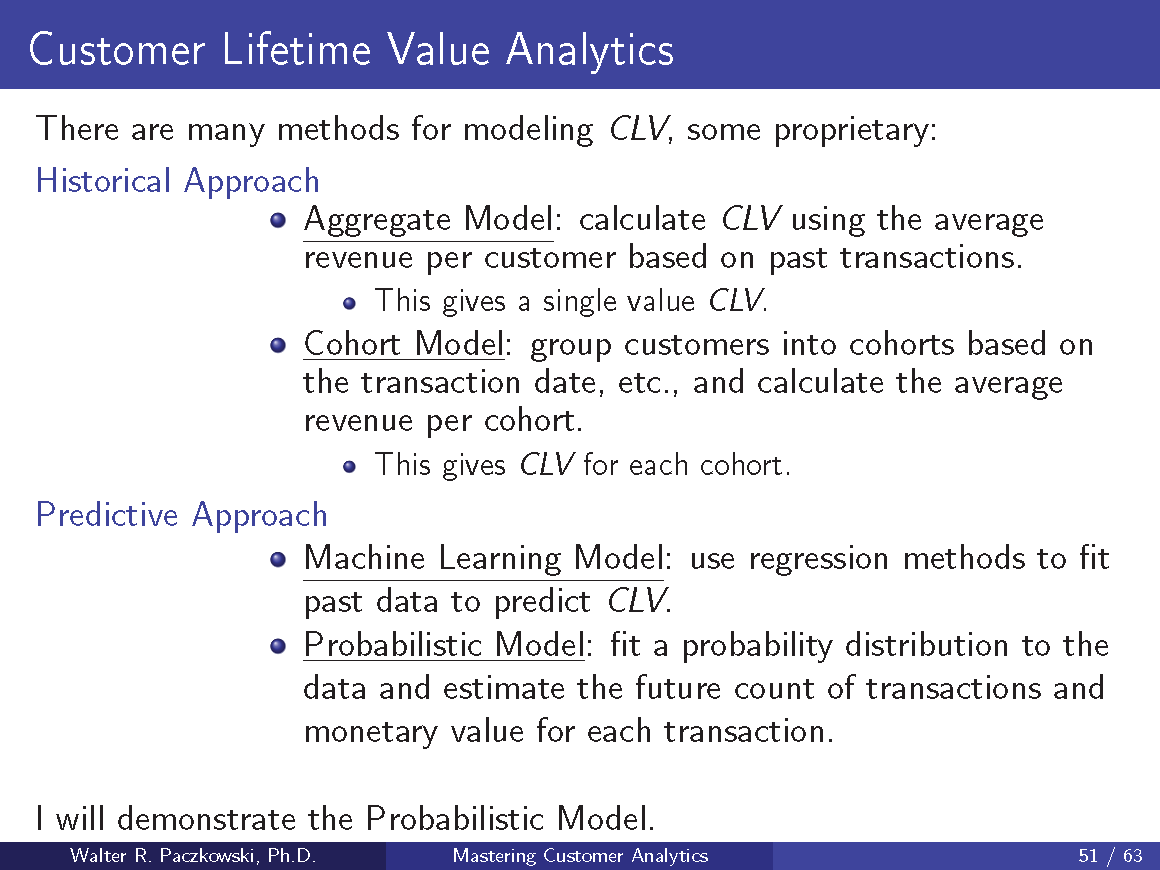

In [74]:
slide( '51' )

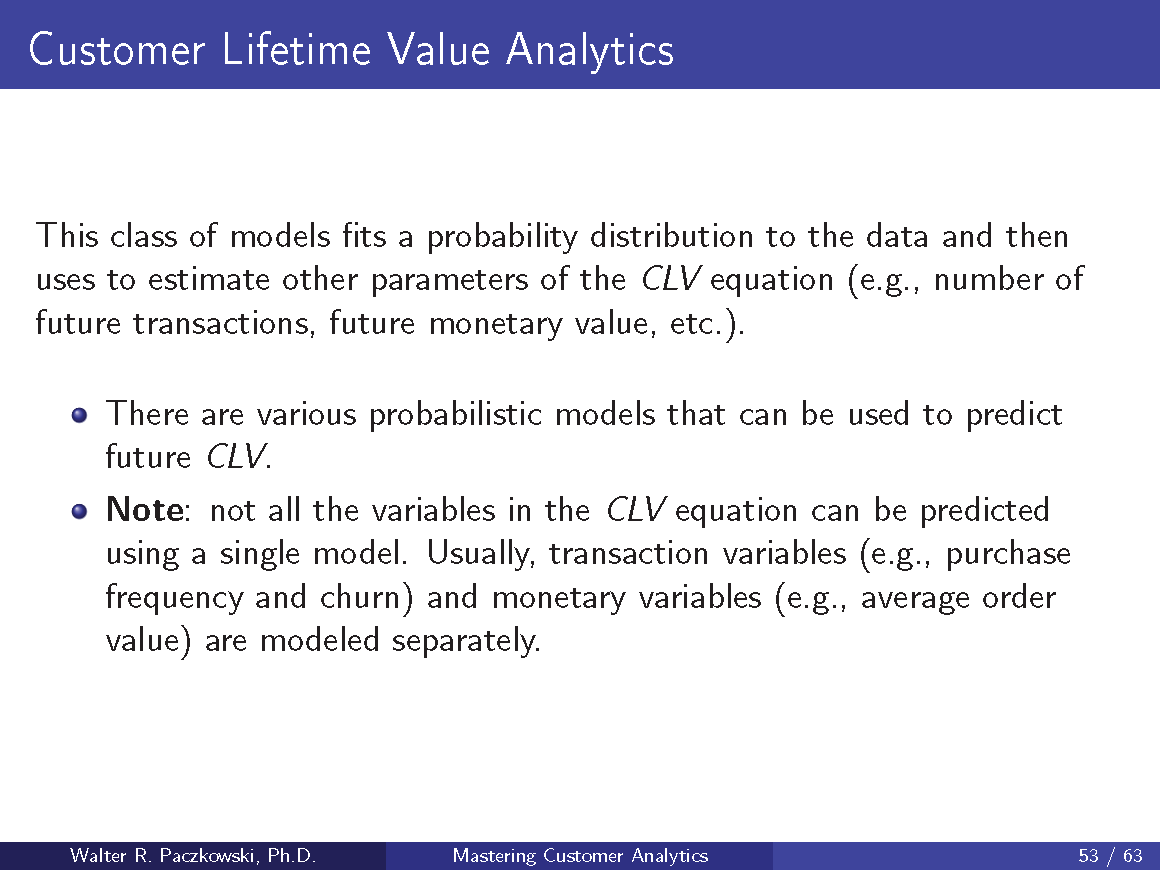

In [75]:
slide( '53' )

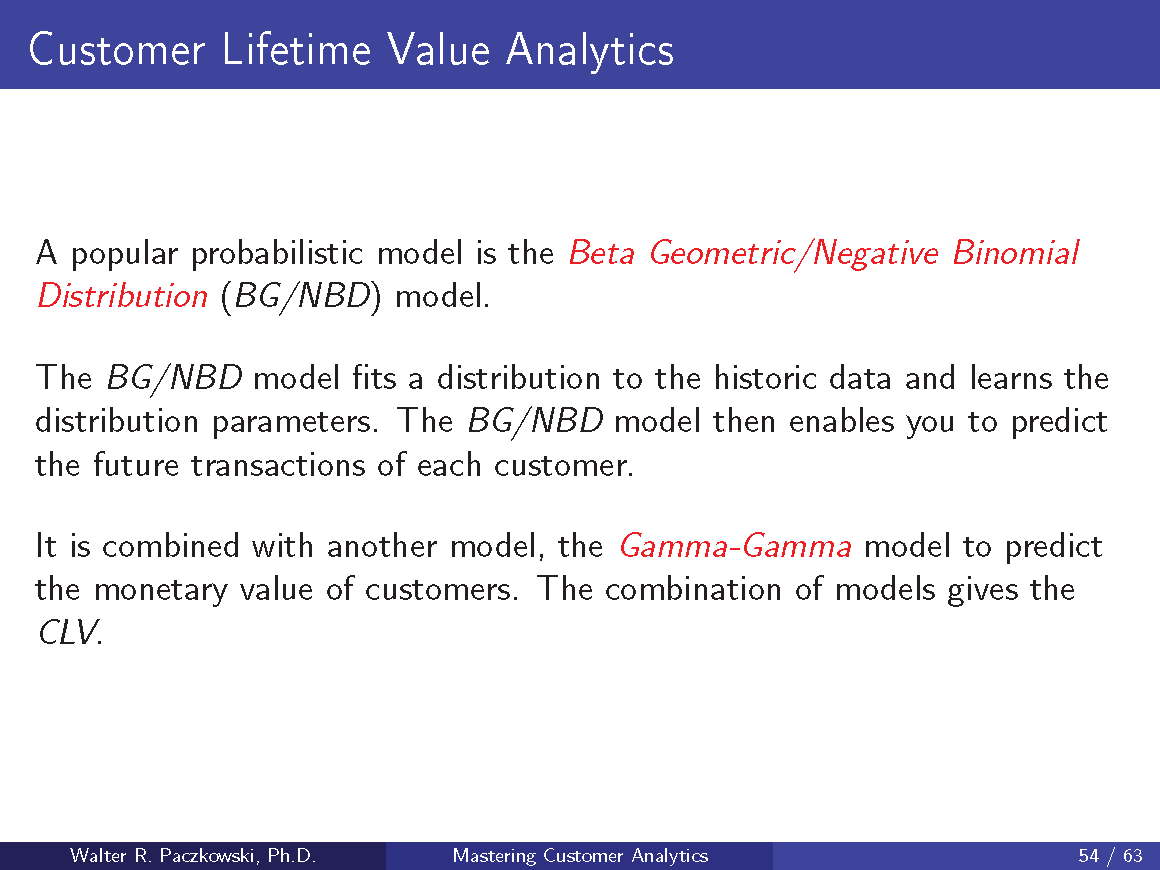

In [76]:
slide( '54' )

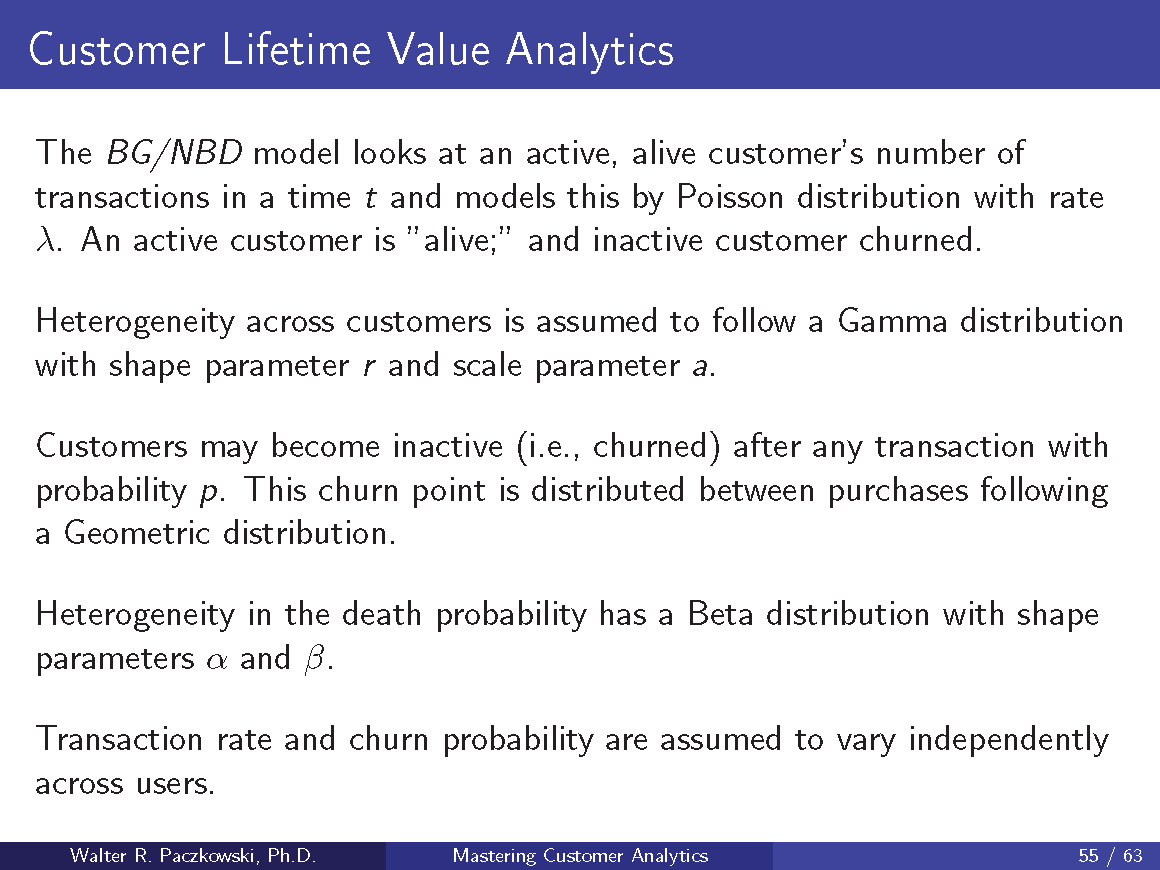

In [77]:
slide( '55' )

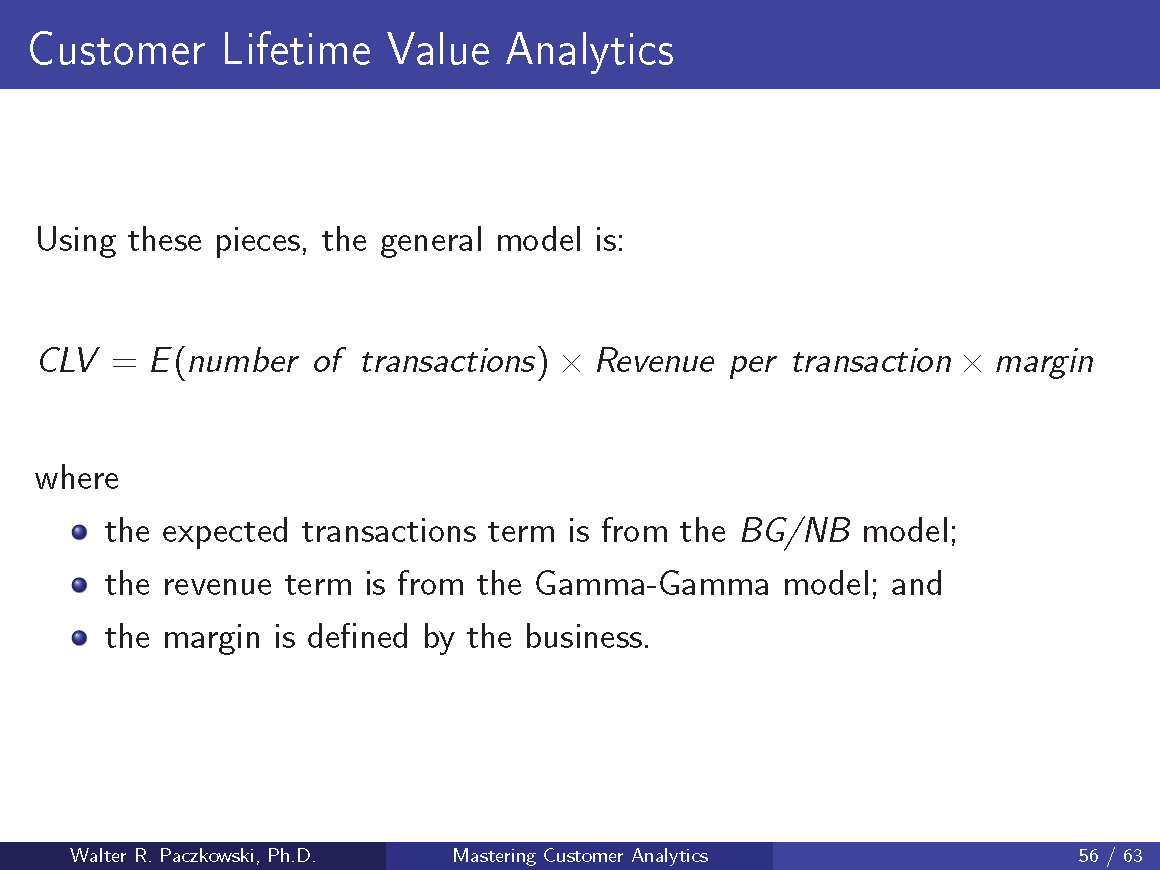

In [78]:
slide( '56' )

## CLV Case Study

[Back to Contents](#Contents)

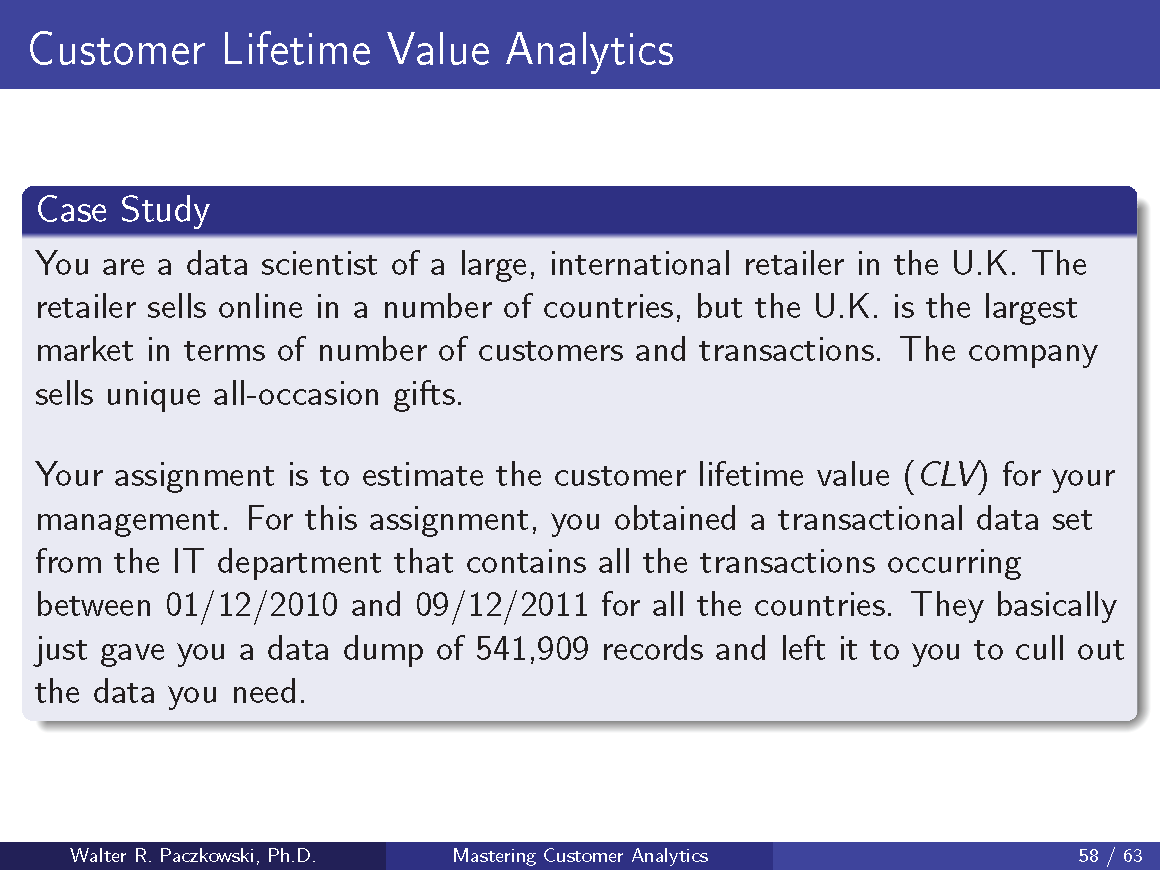

In [79]:
slide( '58' )

## CLV Data Dictionary

[Back to Contents](#Contents)

**Retail Sales Data**

| Variable | Values | Source | Mnemonic |
|----------|--------|--------|----------|
| Invoice Number | Nominal, a 6-digit integral number | UCI | InvoiceNo |
| Product (item) code | Nominal, a 5-digit integral number | UCI | StockCode |
| Product (item) name | String | UCI | Description |
| Quantities of each product (item) per transaction | Numeric | UCI | Quantity |
| Invoice Date and time | Numeric, day and time | UCI | InvoiceDate |
| Unit price | Numeric, price per unit in sterling | UCI | UnitPrice |
| Customer ID | Nominal, 5-digit integral number | UCI | CID |
| Country name | Nominal, name of the country of customer | UCI | Country |

Source: University of California Irvine Machine Learning Repository (*UCI*).

## Import, Examine, and Process the CLV Data

[Back to Contents](#Contents)

In [ ]:
##
## Import the data
##
file = 'onlineRetail.csv'
##
format_dict = {'UnitPrice':'${0:.2f}', 'CID':'{0:.0f}' }
df_retail = pd.read_csv( path + file, parse_dates = [ 'InvoiceDate' ] )
df_retail.rename( columns = { 'CustomerID':'CID' }, inplace = True )
display( df_retail.head().style.set_caption( 'Initial Data Download' ).set_table_styles( tbl_styles ).hide_index().\
       format( format_dict ) )
display( df_size( df_retail ) )

In [ ]:
## 
## Get country distribution
##
df_country = pd.DataFrame( df_retail.Country.value_counts( normalize = True ) )
df_country.rename( columns = {'Country':'Proportion'}, inplace = True ) 
df_country.head().style.set_caption( 'Country Representation' ).set_table_styles( tbl_styles ).\
    format( { 'Proportion':'{:,.1%}'} )

In [ ]:
##
## Subset UK
##
df_uk = df_retail.query( "Country == 'United Kingdom'" ).drop( labels = [ 'Country' ], axis = 1 )
display( df_uk.head().style.set_caption( 'Preprocessed Data' ).set_table_styles( tbl_styles ).
        hide_index().format( format_dict ) )
display( df_size( df_uk ) )

In [ ]:
##
## Display summary statistics
##
display( df_uk.describe().T.style.set_caption( 'Summary Statistics' ).set_table_styles( tbl_styles ).format( p_value ) )

**Interpretation**

Notice the negative quantity and price points.  These represent returns and are not positive business.  I'll delete all records with negative values.

In [ ]:
##
## Drop the records with negative data
##
df_uk = df_uk[ ( df_uk.Quantity > 0 ) & ( df_uk.UnitPrice > 0 ) ]
display( df_uk.describe().T.style.set_caption( 'Summary Statistics' ).set_table_styles( tbl_styles ).format( p_value ) )

In [ ]:
## 
## Check for missing values
##
mvReport( df_uk )

In [ ]:
##
## Drop all records with missing CIDs.  We need to know who the customers are so missing values are a problem.
##
df_uk.dropna( inplace = True )
mvReport( df_uk )

In [ ]:
##
## Calculate total revenue
##
format_dict.update( {'Revenue':'${0:.2f}'})
df_uk[ 'Revenue' ] = df_uk[ 'Quantity' ] * df_uk[ 'UnitPrice' ]
display( df_uk.head().style.set_caption( 'Retail Data' ).set_table_styles( tbl_styles ).\
        hide_index().format( format_dict ) )
display( df_uk.describe().T )

In [ ]:
##
## Print some DataFrame details
##
format_dict = {'total revenue':'${0:,.0f}', 'total quantity':'{0:,.0f}', 'unique customers':'{0:,.0f}'}
data = { 'min Date':df_uk.InvoiceDate.dt.date.min(), 'max Date':df_uk.InvoiceDate.dt.date.max(),
        'unique customers':df_uk.CID.nunique(), 'total quantity':df_uk.Quantity.sum(),
        'total revenue':df_uk.Revenue.sum() }
display( pd.DataFrame( data, index = [0] ).style.set_caption( 'Variable Summaries' ).\
        set_table_styles( tbl_styles ).hide_index().format( format_dict ) )


**Interpretation**

Notice that there are 3,920 unique customers.

## Model CLV

[Back to Contents](#Contents)


Use the *lifetimes* package.

Create a *Recency, Frequency and Monetary Value* (*RFM*) summary table from the transactions data.

The *summary_data_from_transactions_data* function in *lifetimes* package aggregates transaction level data and calculates for each customer:

>- **frequency**: the number of repeat purchases (more than 1 purchases).
>- **recency**: the time between the first and the last transaction.
>- **T**: the time between the first purchase and the end of the transaction period.
>- **monetary_value**: it is the mean of a given customer's sales value (i.e., Revenue).


In [ ]:
##
## Create summary data using summary_data_from_transaction_data function.
##
format_dict = { 'CID':'{0:.0f}', 'T':'{0:.0f}', 'frequency':'{0:.0f}', 'recency':'{0:.0f}', 'monetary_value':'${0:,.2f}'}
summary = lifetimes.utils.summary_data_from_transaction_data( df_uk, 'CID', 'InvoiceDate', 'Revenue' )
summary = summary.reset_index()
base = summary.shape[ 0 ]
display( summary.head().style.set_caption( 'RFM Summary Data' ).set_table_styles( tbl_styles ).format( format_dict ).hide_index() )
boldprt( f'Base: {base} customers' )

**Interpretation**

Notice that the monetary value is based on the calculated Revenue (unit sales $\times$ price).  This is not net profit.

The value 0 for frequency and recency means these are one-time buyers. Let's check how many such one-time buyers there are in the DataFrame.

In [ ]:
##
## Plot distribution of frequency
##
ax = summary[ 'frequency' ].plot( kind = 'hist', bins = 50 )
ax.set_title( 'Frequency Distribution', fontsize = font_title )
boldprt( 'Summary Statistics\n')
print( summary[ 'frequency' ].describe() )
print( "-"*60 )
one_time_buyers = round( sum( summary[ 'frequency' ] == 0)/float( len( summary ) )*( 100 ), 2 )
print( f"Percentage of customers purchase the item once: {one_time_buyers}%" )

*BG/NBD* model is available as *BetaGeoFitter* class in *lifetimes* package.

In [ ]:
##
## Fit the BG/NBD model
##
## ===> Step 1: Instantiate the model <===
##
bgf = lifetimes.BetaGeoFitter( penalizer_coef = 0.0 )
##
## ===> Step 2: Fit the model <===
##
bgf01 = bgf.fit( summary[ 'frequency' ], summary[ 'recency' ], summary[ 'T' ] )
##
## ===> Step 3: Summarize the model <===
##
display( bgf.summary.style.set_caption( 'BG/NBD Model Summary' ).set_table_styles( tbl_styles ).format( p_value ) )
boldprt( 'Base: Model bgf01' )

Suppose you want to know whether a customer is alive or not (i.e., predict customer churn) based on the historical data. Use *model.conditional_probability_alive()* in *lifetimes* to compute the probability that a customer with the 3-tuple  history (frequency, recency, T) is currently alive.  You can then plot this using *plot_probabilty_alive_matrix(model)*.

In [ ]:
##
## Compute the customer alive probability
##
format_dict.update( {'probability_alive':'{0:.3f}'})
summary['probability_alive'] = bgf.conditional_probability_alive( summary[ 'frequency' ],\
                                        summary[ 'recency' ], summary[ 'T' ] )
display( summary.head(10).style.set_caption( "Customer 'Alive' Probability" ).set_table_styles( tbl_styles ).\
        hide_index().format( format_dict ) )
boldprt( 'Base: Model bgf01' )

In [ ]:
##
## Set threshold for classifying customers as alive or dead:
##   probability_alive > theta, then Alive; else, Churned 
##
theta = 0.75
##
## Score customers
##
base = summary.shape[ 0 ]
summary[ 'Alive' ] = [ 'Alive' if x > theta else 'Churned' for x in summary.probability_alive ]
display( summary.head(10).style.set_caption( "Customer 'Alive' Status" ).set_table_styles( tbl_styles ).hide_index().format( format_dict ) )
boldprt( f'Base: {base} customers' )

**Interpretation**

The probabilty of being alive is calculated based on the recency and frequency of a customer. So,

>1. If a customer has bought multiple times (frequency) and the time between first & last transaction is high (recency), then his/her probability being alive is high.
>2. If a customer has less frequency (bought once or twice) and the time between first & last transaction is low (recency), then his/her probability being alive is high.

In [ ]:
##
## Examine Alive/Churn status
##
status = summary.Alive.value_counts( normalize = True )
tmp = pd.DataFrame( status )
tmp.rename( columns = { "Alive": "Status" }, inplace = True )
display( tmp.style.set_caption( "Alive/Churn Status" ).set_table_styles( tbl_styles ).format( format ) )

## Predict with the CLV Model

[Back to Contents](#Contents)

Use the trained model to predict the likely future transactions of each customer.  Use the *conditional_expected_number_of_purchases_up_to_time* method in *lifetimes.*

In [ ]:
##
## Predict transactions for the next 30 days based on historical data
##
## Set steps-ahead parameter
##
t = 30
##
## Predict
##
summary[ 'predicted_trans' ] = round( bgf.conditional_expected_number_of_purchases_up_to_time\
                                ( t, summary[ 'frequency' ], summary[ 'recency' ], summary[ 'T' ] ), 2 )
##
format_dict.update( {'predicted_trans':'{0:.2f}'})
summary_sorted = summary.sort_values( by = 'predicted_trans', ascending = False )
display( summary_sorted.head().\
       style.set_caption( 'Predicted Future Transactions: 30 Days Ahead' ).set_table_styles( tbl_styles ).\
       hide_index().format( format_dict ) )

## Model CLV Monetary Value

[Back to Contents](#Contents)

In [ ]:
##
## Check the relationship between frequency and monetary_value
##
return_customers_summary = summary[ summary[ 'frequency' ] > 0 ]
base = 'Base: ' + str( return_customers_summary.shape[ 0 ] ) + ' customers'
display( return_customers_summary.head().style.set_caption( 'Predicted Transactions' ).set_table_styles( tbl_styles ).\
        hide_index().format( format_dict ) )
boldprt( base )

In [ ]:
##
## Check correlation between frequency and monetary_value
##
cols = ['frequency', 'monetary_value']
display( return_customers_summary[ cols ].corr().style.set_caption( 'Correlation Between Frequency & Value' ).\
        set_table_styles( tbl_styles ).format( '{:0.2f}' ) )

**Interpretation**

The correlation are very weak. Hence, the assumption is satisfied and we can fit the model to our data.

In [ ]:
## 
## Model the monetary value using the Gamma-Gamma Model
##
## ===> Step 1: Instantiate the model <===
##
ggf = lifetimes.GammaGammaFitter( penalizer_coef = 0.001 )
##
## ===> Step 2: Fit the model <===
##
ggf01 = ggf.fit( return_customers_summary[ 'frequency' ], return_customers_summary[ 'monetary_value' ] )
##
## ===> Step 3: Summarize the model <===
##
display( ggf.summary.style.set_caption( 'GGF Model Summary' ).set_table_styles( tbl_styles ).format( p_value ) )
boldprt( 'Base: Model ggf01' )

Predict the expected average profit for each transaction and the *CLV* using the model. Use:

>1. *model.conditional_expected_average_profit()*: This method computes the conditional expectation of the average profit per transaction for a group of one or more customers.
>2. *model.customer_lifetime_value()*: This method computes the average lifetime value of a group of one or more customers. This method takes the *BG/NBD* model and the prediction horizon as a parameter to calculate the *CLV*.

In [ ]:
##
## Calculate the conditional expected average profit for each customer per transaction
##
format_dict.update( {'exp_avg_sales':'${0:,.2f}'})
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
display( summary.head().style.set_caption( 'Summary Measures' ).set_table_styles( tbl_styles).\
        hide_index().format( format_dict ) ) 

**Interpretation**

The expected average sales is based on the actual sales value, not profit. We can use the model to get *predicted CLV* and then multiply that by a profit margin to get a profit value.

In [ ]:
##
## Predict CLV for the next 30 days; set discount rate to 1% (0.01)
##
format_dict.update( {'predicted_clv':'${0:,.2f}'})
summary[ 'predicted_clv' ] = ggf.customer_lifetime_value( bgf, summary[ 'frequency' ], summary[ 'recency' ], summary[ 'T' ],\
                                                       summary[ 'monetary_value' ], 
                                                       time = 1,             # lifetime in months
                                                       freq = 'D',           # frequency in which the data is present(T)      
                                                       discount_rate = 0.01  # discount rate
                                                    )
display( summary.head().style.set_caption( 'Summary' ).set_table_styles( tbl_styles).hide_index().format( format_dict ) ) 

**Interpretation**

The predicted *CLV* is sales volume.  Need to calculate net profit using the profit margin.

In [ ]:
##
## Calculate CLV in terms of net profit for each customer (profit margin = 5%)
## Net profit for each customer is sales value times profit margin.
##
profit_margin = 0.05
##
format_dict.update( {'CLV':'${0:,.2f}'})
summary[ 'CLV' ] = summary[ 'predicted_clv' ] * profit_margin
display( summary.head().style.set_caption( 'Summary' ).set_table_styles( tbl_styles).\
        hide_index().format( format_dict ) ) 

In [ ]:
##
## Display the distribution of CLV for the next 30 days
##
display( summary[ 'CLV' ].describe() )

<div class="alert alert-info" role="alert">
    
<font color = black>Summary and Wrap-up
---------------------------------------
    
[Back to Contents](#Contents)  
    
</div>


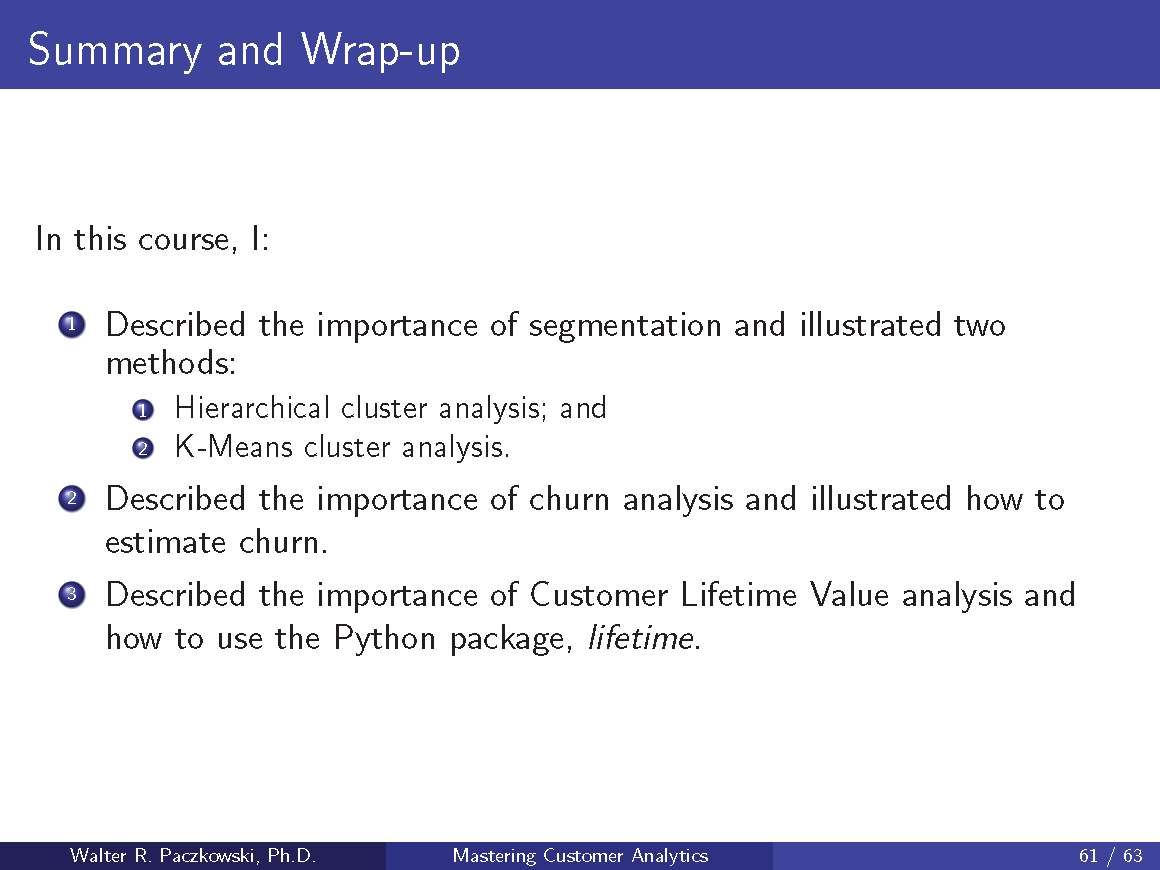

In [80]:
slide( '61' )

<div class="alert alert-info" role="alert">
    
<font color = black>Contact Information
---------------------------------------
    
[Back to Contents](#Contents)  
    
</div>

If you have any questions after this course, please do not hesitate to contact me.